In [1]:
!pip install dicomsdl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.3 MB/s eta 0:00:0000:010:01


In [ ]:
import numpy as np
import pydicom
import os
from tqdm import tqdm  # Importar la versión de tqdm para notebooks
from pathlib import Path
import dicomsdl
import multiprocessing as mp
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.amp import GradScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Completamos el df con la ubicación de cada imagen png

In [5]:
!mv /kaggle/working/processed_images.zip /kaggle/output/


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


mv: cannot stat '/kaggle/working/processed_images.zip': No such file or directory


In [ ]:
# Abrir Conjunto de datos
train_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')


In [ ]:
#Ruta Imagenes
base_path='/kaggle/input/pi-mamographies/kaggle/working/train_images_processed_cv2_dicomsdl_512'
# Guardar la ruta de las imagenes en  train_df
train_df['img_path']= f'{base_path}'\
                    +  '/' +train_df.patient_id.astype(str)\
                    + '/' + train_df.image_id.astype(str)\
                    + '.png'


In [9]:
display(train_df.head(10))
train_df.iloc[0,14]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/pi-mamographies/kaggle/working/t...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/pi-mamographies/kaggle/working/t...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/pi-mamographies/kaggle/working/t...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/pi-mamographies/kaggle/working/t...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/pi-mamographies/kaggle/working/t...
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/pi-mamographies/kaggle/working/t...
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/pi-mamographies/kaggle/working/t...
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/pi-mamographies/kaggle/working/t...
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/pi-mamographies/kaggle/working/t...
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/pi-mamographies/kaggle/working/t...


'/kaggle/input/pi-mamographies/kaggle/working/train_images_processed_cv2_dicomsdl_512/10006/462822612.png'

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  img_path              

In [11]:
train_df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


Validación de variables con nulos

In [12]:
train_df.BIRADS.value_counts()

BIRADS
1.0    15772
0.0     8249
2.0     2265
Name: count, dtype: int64

In [13]:
# Filtrar pacientes con BIRADS NaN y verificar si tienen cáncer
patients_with_nan_BIRADS = train_df[train_df['BIRADS'].isna()]
patients_with_cancer_nan_BIRADS = patients_with_nan_BIRADS[patients_with_nan_BIRADS['cancer'] == 1]

# Cantidad de pancientes con cancer y clasificación BIRADS nan
print(len(patients_with_cancer_nan_BIRADS))

494


In [14]:
# Reemplazar los valores NaN en la columna BIRADS con 0 solo si la paciente tiene cáncer
train_df.loc[(train_df['BIRADS'].isna()) & (train_df['cancer'] == 1), 'BIRADS'] = 0

In [15]:
#Se cambian valores nulos en variable BIRADS por 2, suponiendo que todos estos casos no obtuvieron una clasificación de BIRADS por parte del radiologo que hizo 
#la evaluación y que la mama no presentó ningun tipo de hallazgo (0 si la mama requirió seguimiento, 
# 1 si la mama se calificó como negativa para cáncer y 
# 2 si la mama se calificó como normal)
train_df.BIRADS.fillna(2,inplace=True)

/tmp/ipykernel_30/1059150911.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df.BIRADS.fillna(2,inplace=True)


In [16]:
#Verificamos variable despues de la imputación
train_df.BIRADS.value_counts()

BIRADS
2.0    30191
1.0    15772
0.0     8743
Name: count, dtype: int64

In [17]:
#Validamos densidad
train_df.density.value_counts()

density
B    12651
C    12175
A     3105
D     1539
Name: count, dtype: int64

In [18]:
# Contar el número de pacientes con cáncer por cada clasificación de densidad
count_by_density = train_df[train_df['cancer'] == 1]['density'].value_counts()

# Mostrar el resultado
print(count_by_density)

density
B    309
C    277
A     53
D     25
Name: count, dtype: int64


In [19]:
# Calcular la proporción de cada categoría de densidad
density_proportions = train_df['density'].value_counts(normalize=True)

# Reemplazar los valores faltantes de la columna 'density' con base en la proporción
missing_density_count = train_df['density'].isna().sum()

# Generar valores aleatorios basados en la proporción calculada
replacements = np.random.choice(
    density_proportions.index,
    size=missing_density_count,
    p=density_proportions.values
)

# Asignar los valores aleatorios a las posiciones donde 'density' es NaN
train_df.loc[train_df['density'].isna(), 'density'] = replacements

print(train_df['density'].value_counts())

density
B    23474
C    22654
A     5773
D     2805
Name: count, dtype: int64


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   54706 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  54706 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  img_path              

cancer
0    53548
1     1158
Name: count, dtype: int64


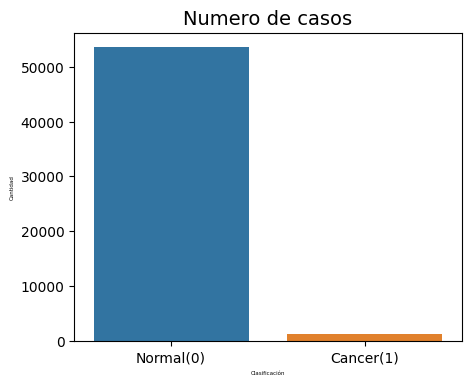

In [ ]:
cases_count = train_df['cancer'].value_counts()
print(cases_count)

# Cantidad de casos de cáncer 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Numero de casos', fontsize=14)
plt.xlabel('Clasificación', fontsize=4)
plt.ylabel('Cantidad', fontsize=4)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Cancer(1)'])
plt.show()

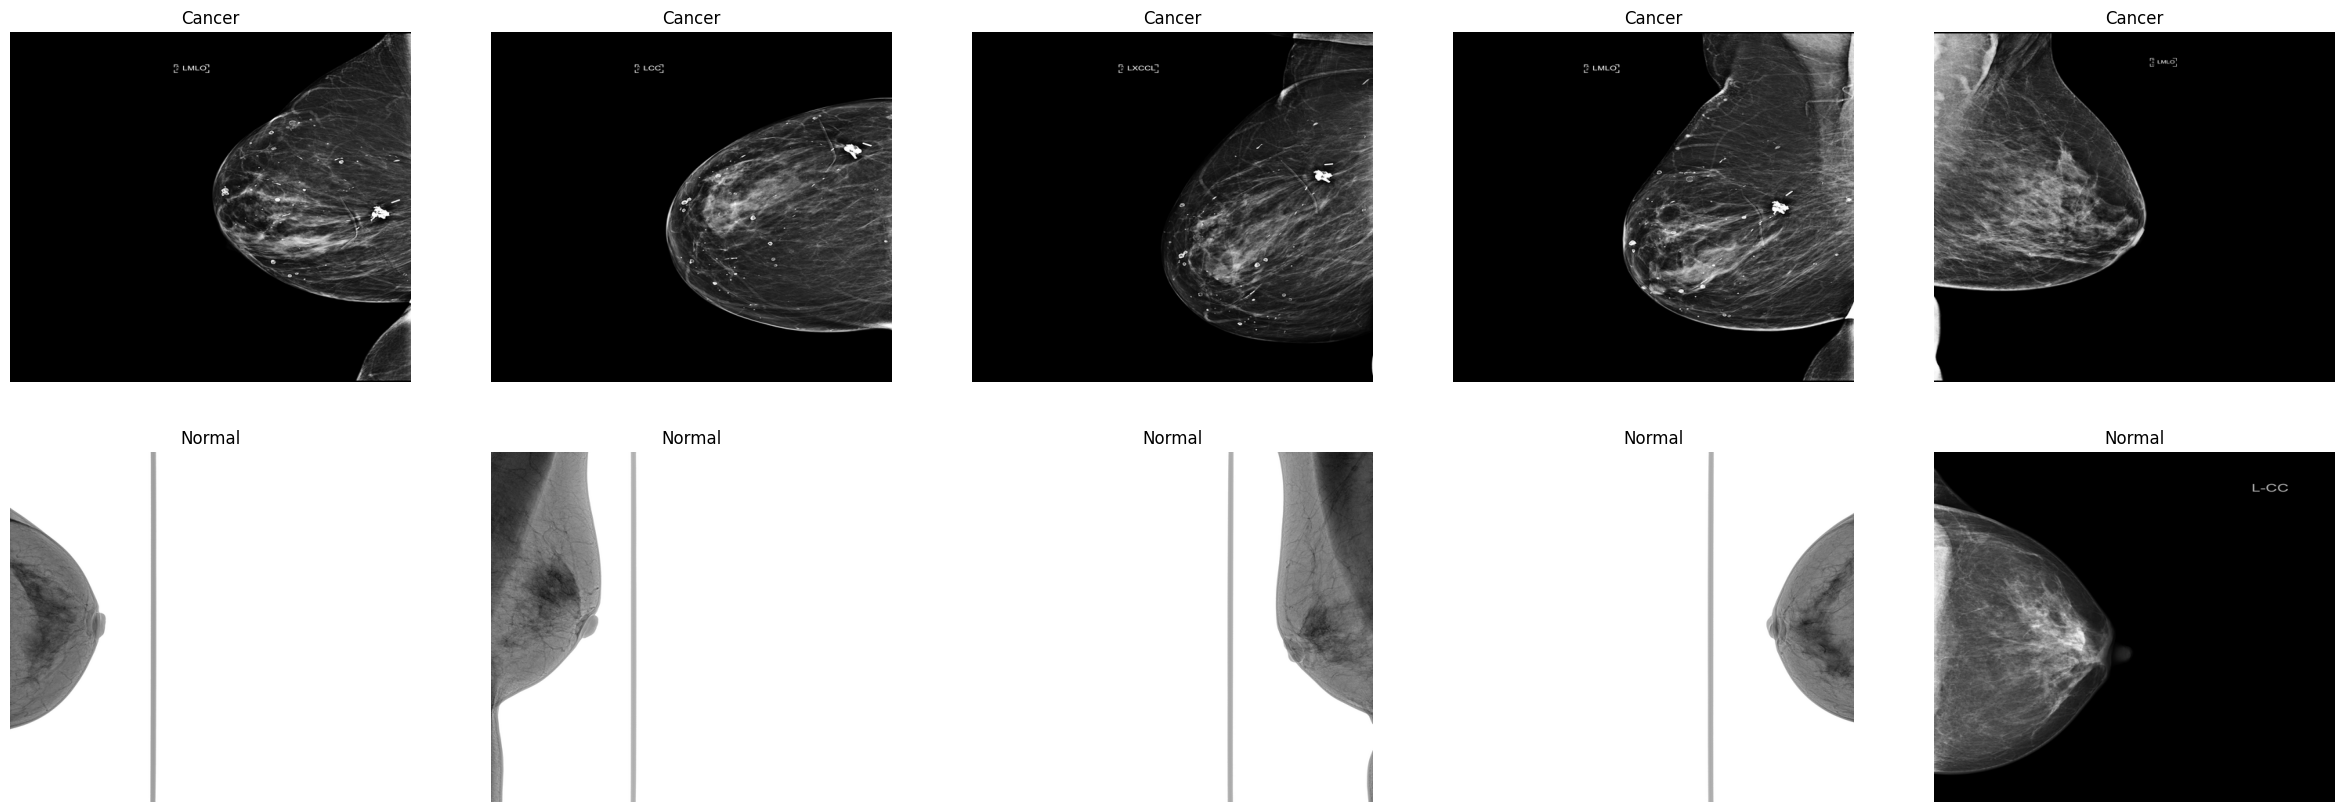

In [21]:
#Visualizar imagenes clasificadas con cancer y no cancer
Cancer_samples = (train_df[train_df['cancer']==1]['img_path'].iloc[0:5]).tolist()
Normal_samples = (train_df[train_df['cancer']==0]['img_path'].iloc[0:5]).tolist()

samples = Cancer_samples + Normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = tf.keras.preprocessing.image.load_img(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Cancer")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


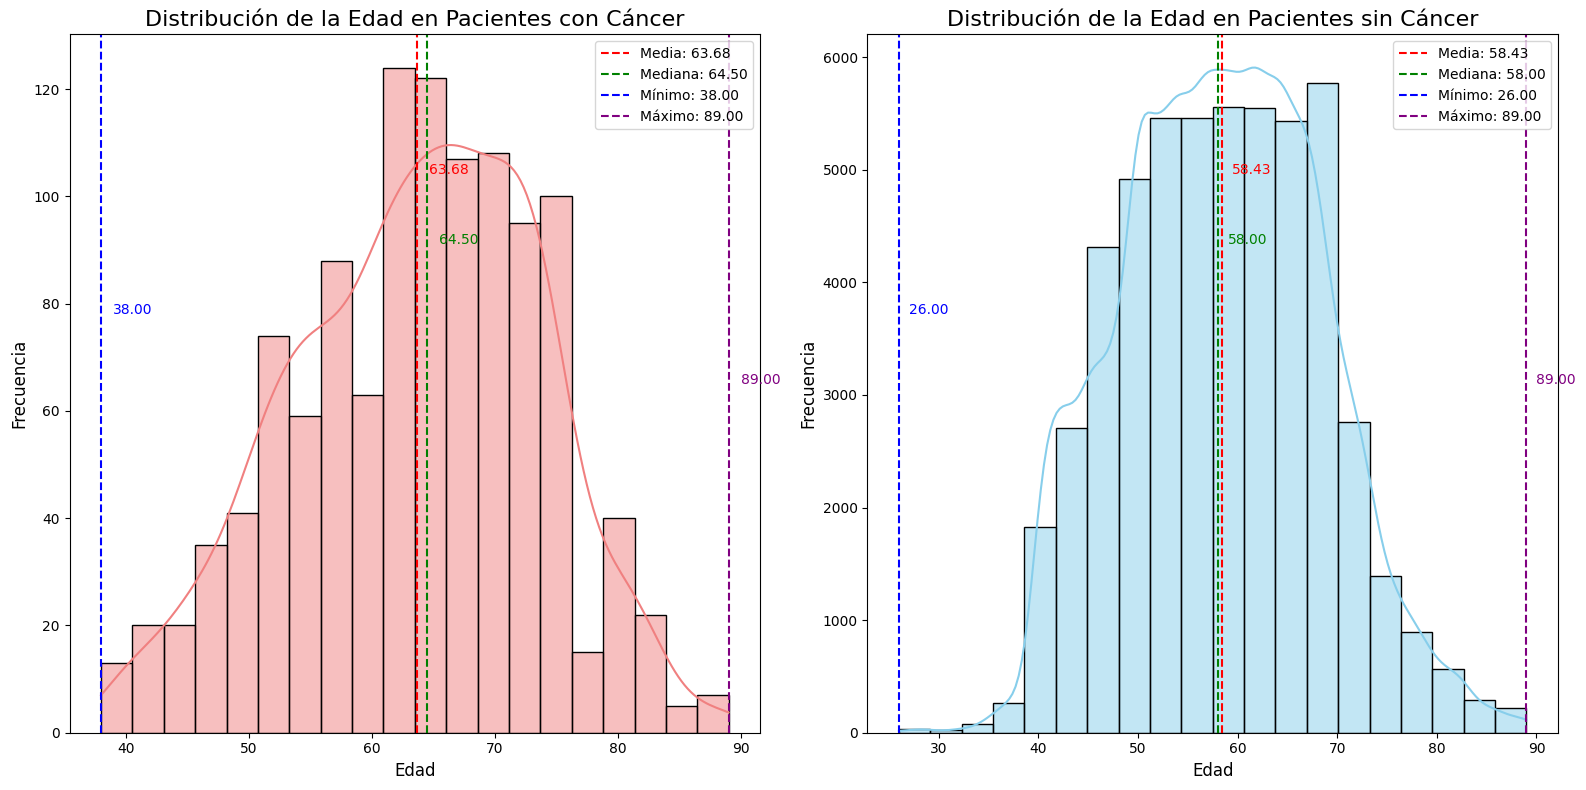

In [22]:
# Separar los datos entre pacientes con cáncer y sin cáncer
cancer_df = train_df[train_df['cancer'] == 1]
no_cancer_df = train_df[train_df['cancer'] == 0]

# Crear una figura con dos gráficos (uno para cáncer, otro para no cáncer)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Gráfico para pacientes con cáncer ---
sns.histplot(cancer_df['age'], kde=True, bins=20, color='lightcoral', edgecolor='black', ax=axes[0])

# Calcular estadísticos para pacientes con cáncer
mean_age_cancer = cancer_df['age'].mean()
median_age_cancer = cancer_df['age'].median()
min_age_cancer = cancer_df['age'].min()
max_age_cancer = cancer_df['age'].max()

# Añadir líneas de estadísticos
axes[0].axvline(mean_age_cancer, color='red', linestyle='--', label=f'Media: {mean_age_cancer:.2f}')
axes[0].axvline(median_age_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_cancer:.2f}')
axes[0].axvline(min_age_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_cancer:.2f}')
axes[0].axvline(max_age_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_cancer:.2f}')
# Añadir anotaciones
axes[0].text(mean_age_cancer + 1, axes[0].get_ylim()[1] * 0.8, f'{mean_age_cancer:.2f}', color='red')
axes[0].text(median_age_cancer + 1, axes[0].get_ylim()[1] * 0.7, f'{median_age_cancer:.2f}', color='green')
axes[0].text(min_age_cancer + 1, axes[0].get_ylim()[1] * 0.6, f'{min_age_cancer:.2f}', color='blue')
axes[0].text(max_age_cancer + 1, axes[0].get_ylim()[1] * 0.5, f'{max_age_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes con cáncer
axes[0].set_title('Distribución de la Edad en Pacientes con Cáncer', fontsize=16)
axes[0].set_xlabel('Edad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].legend()

# --- Gráfico para pacientes sin cáncer ---
sns.histplot(no_cancer_df['age'], kde=True, bins=20, color='skyblue', edgecolor='black', ax=axes[1])

# Calcular estadísticos para pacientes sin cáncer
mean_age_no_cancer = no_cancer_df['age'].mean()
median_age_no_cancer = no_cancer_df['age'].median()
min_age_no_cancer = no_cancer_df['age'].min()
max_age_no_cancer = no_cancer_df['age'].max()
# Añadir líneas de estadísticos
axes[1].axvline(mean_age_no_cancer, color='red', linestyle='--', label=f'Media: {mean_age_no_cancer:.2f}')
axes[1].axvline(median_age_no_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_no_cancer:.2f}')
axes[1].axvline(min_age_no_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_no_cancer:.2f}')
axes[1].axvline(max_age_no_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_no_cancer:.2f}')

# Añadir anotaciones
axes[1].text(mean_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.8, f'{mean_age_no_cancer:.2f}', color='red')
axes[1].text(median_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.7, f'{median_age_no_cancer:.2f}', color='green')
axes[1].text(min_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.6, f'{min_age_no_cancer:.2f}', color='blue')
axes[1].text(max_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.5, f'{max_age_no_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes sin cáncer
axes[1].set_title('Distribución de la Edad en Pacientes sin Cáncer', fontsize=16)
axes[1].set_xlabel('Edad', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend()
# Mostrar el gráfico
plt.tight_layout()
plt.show()

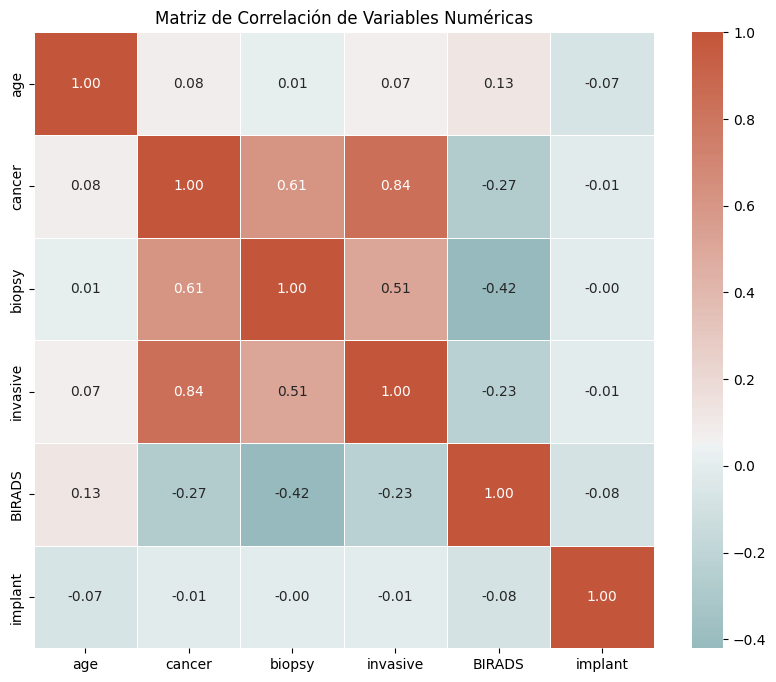

<Figure size 640x480 with 0 Axes>

In [ ]:
# Seleccionar solo las columnas numéricas del DataFrame
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación variables principales
corr_matrix = numeric_df[['age', 'cancer', 'biopsy',
       'invasive', 'BIRADS', 'implant']].corr()

# Crear un mapa de colores que haga las correlaciones bajas (cercanas a 0) en gris y las altas en otro color
# Usamos un colormap personalizado
cmap = sns.diverging_palette(200, 20, as_cmap=True)  # Puedes ajustar los colores aquí

# Crear el gráfico de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, center=0.05)  # 'center=0' centra el mapa de colores
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

plt.savefig('/kaggle/working/Correlaciones.jpeg')

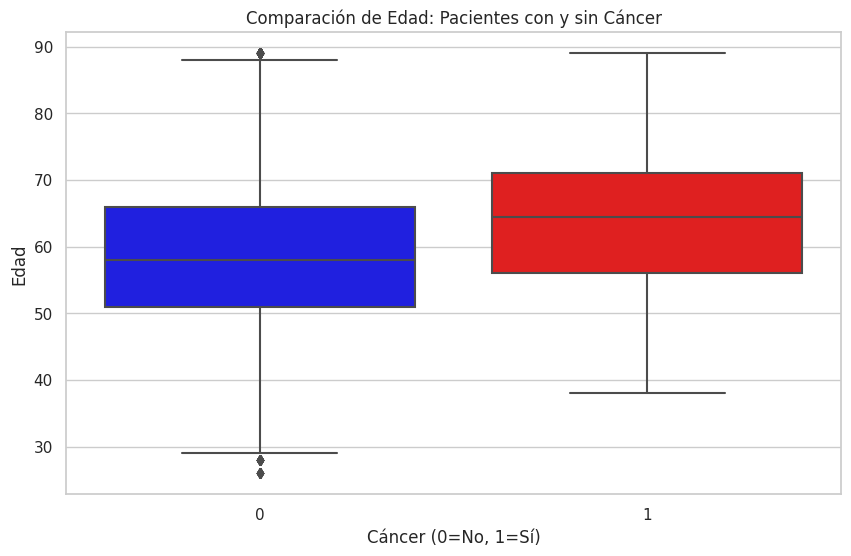

In [24]:
# Filtrar los pacientes con cáncer y sin cáncer
cancer_patients = train_df[train_df['cancer'] == 1]
no_cancer_patients = train_df[train_df['cancer'] == 0]

# Configurar estilo visual
sns.set(style="whitegrid")

# Boxplot para comparar las distribuciones de edad
plt.figure(figsize=(10, 6))
sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])
plt.title('Comparación de Edad: Pacientes con y sin Cáncer')
plt.xlabel('Cáncer (0=No, 1=Sí)')
plt.ylabel('Edad')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


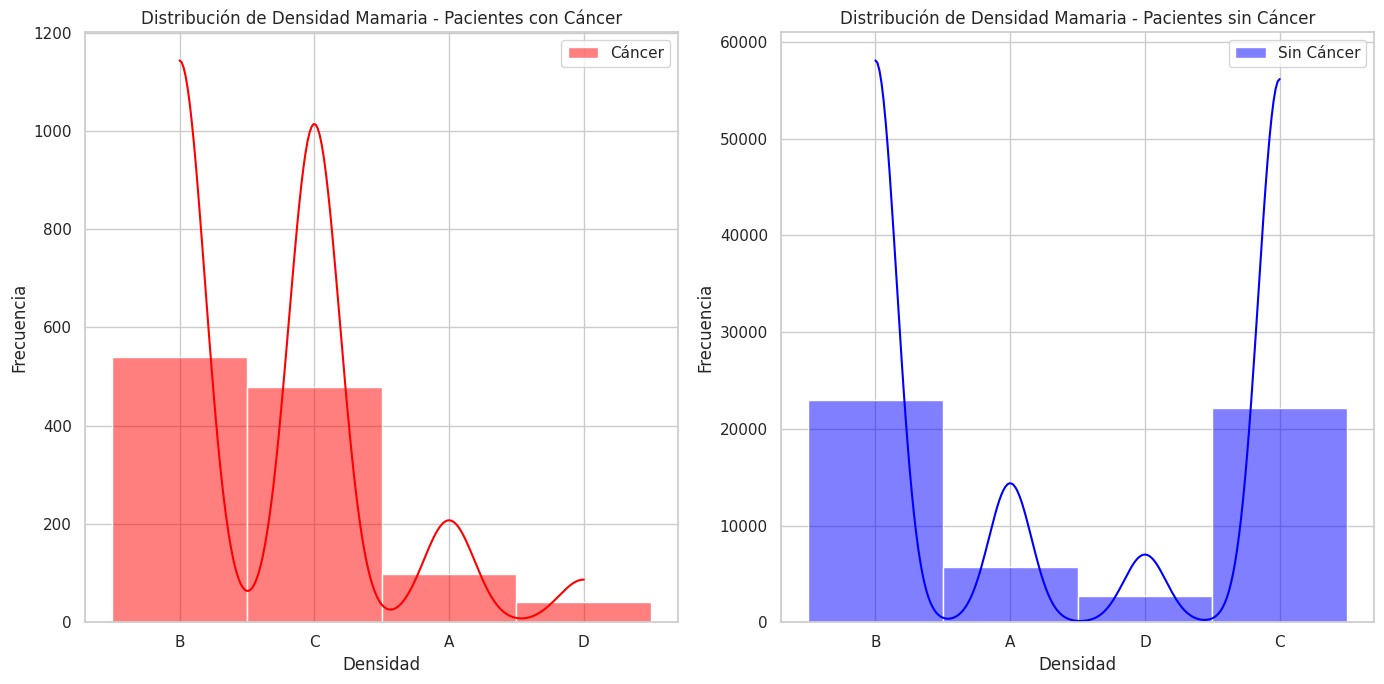

In [25]:
# Histograma para visualizar la distribución de la densidad
plt.figure(figsize=(14, 7))

# Densidad en pacientes con cáncer
plt.subplot(1, 2, 1)
sns.histplot(cancer_patients['density'], kde=True, bins=20, color='red', label='Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes con Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

# Densidad en pacientes sin cáncer
plt.subplot(1, 2, 2)
sns.histplot(no_cancer_patients['density'], kde=True, bins=20, color='blue', label='Sin Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes sin Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

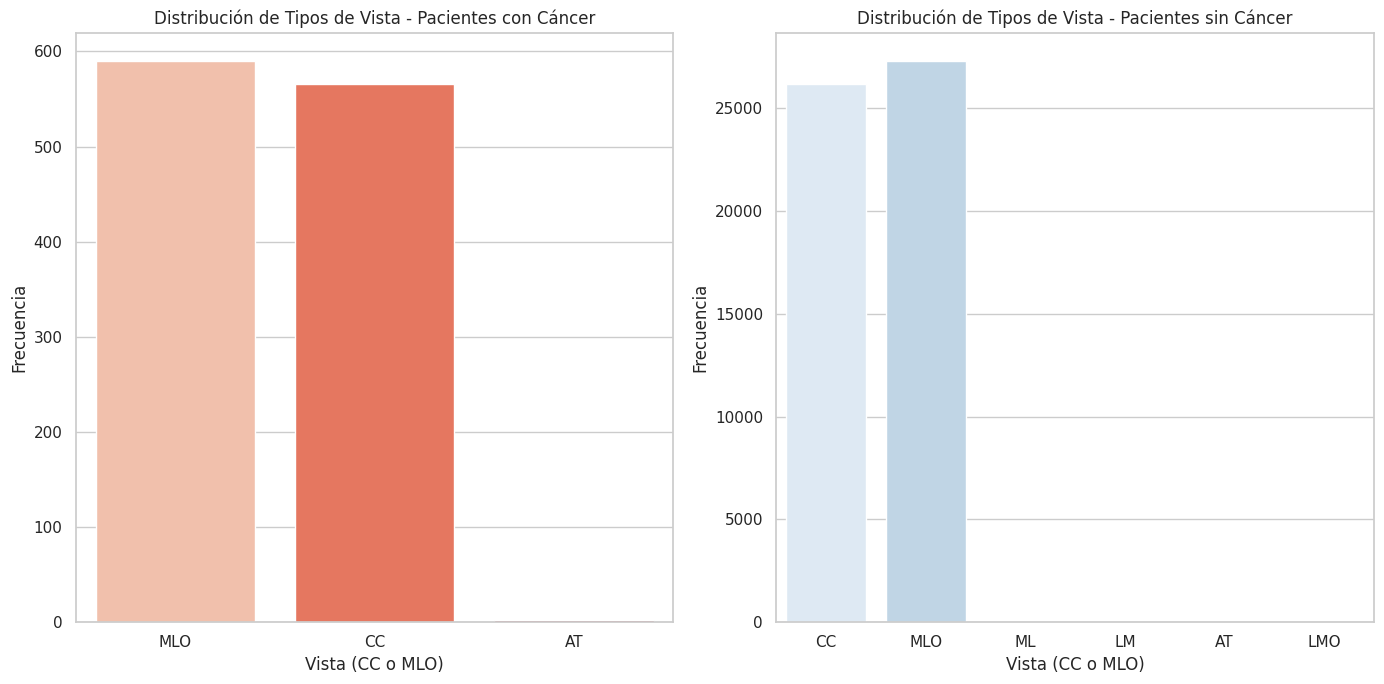

In [26]:
# Configurar estilo visual
sns.set(style="whitegrid")

# Gráfico de barras para tipo de vista en pacientes con cáncer
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(data=cancer_patients, x='view', palette='Reds')
plt.title('Distribución de Tipos de Vista - Pacientes con Cáncer')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

# Gráfico de barras para tipo de vista en pacientes sin cáncer
plt.subplot(1, 2, 2)
sns.countplot(data=no_cancer_patients, x='view', palette='Blues')
plt.title('Distribución de Tipos de Vista - Pacientes sin Cáncer')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


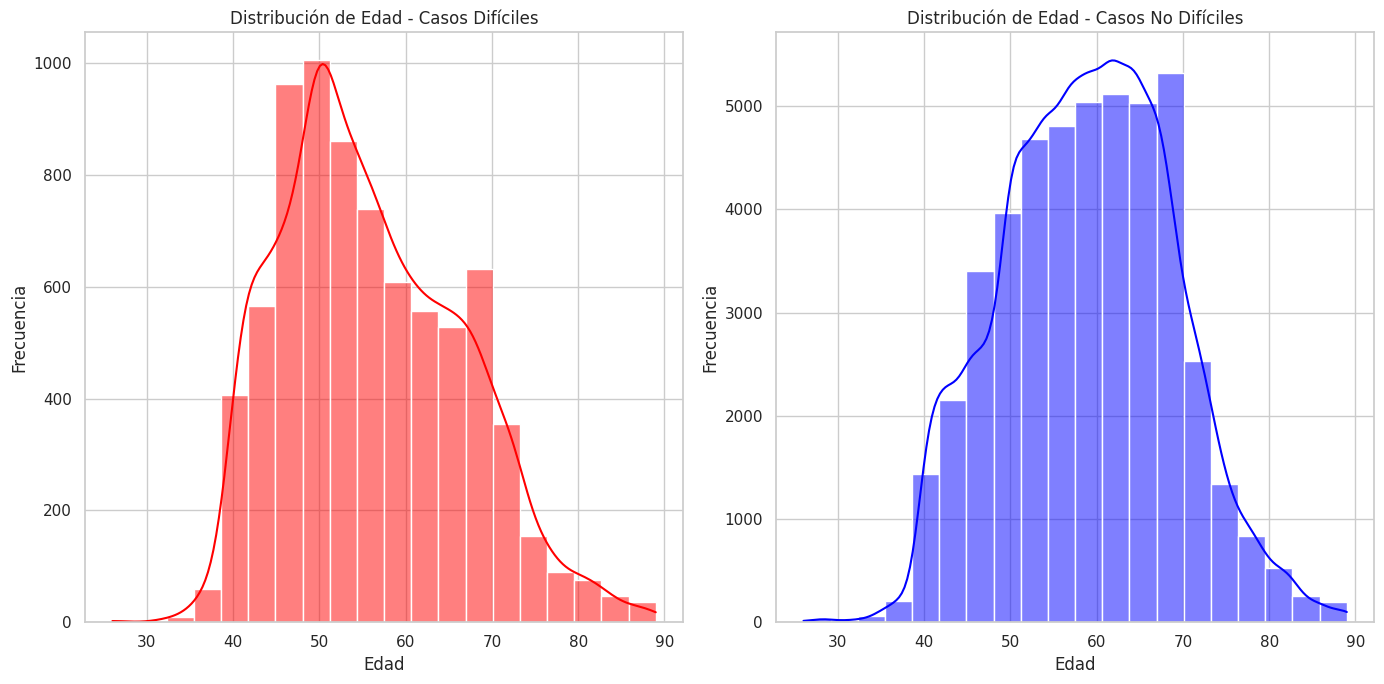

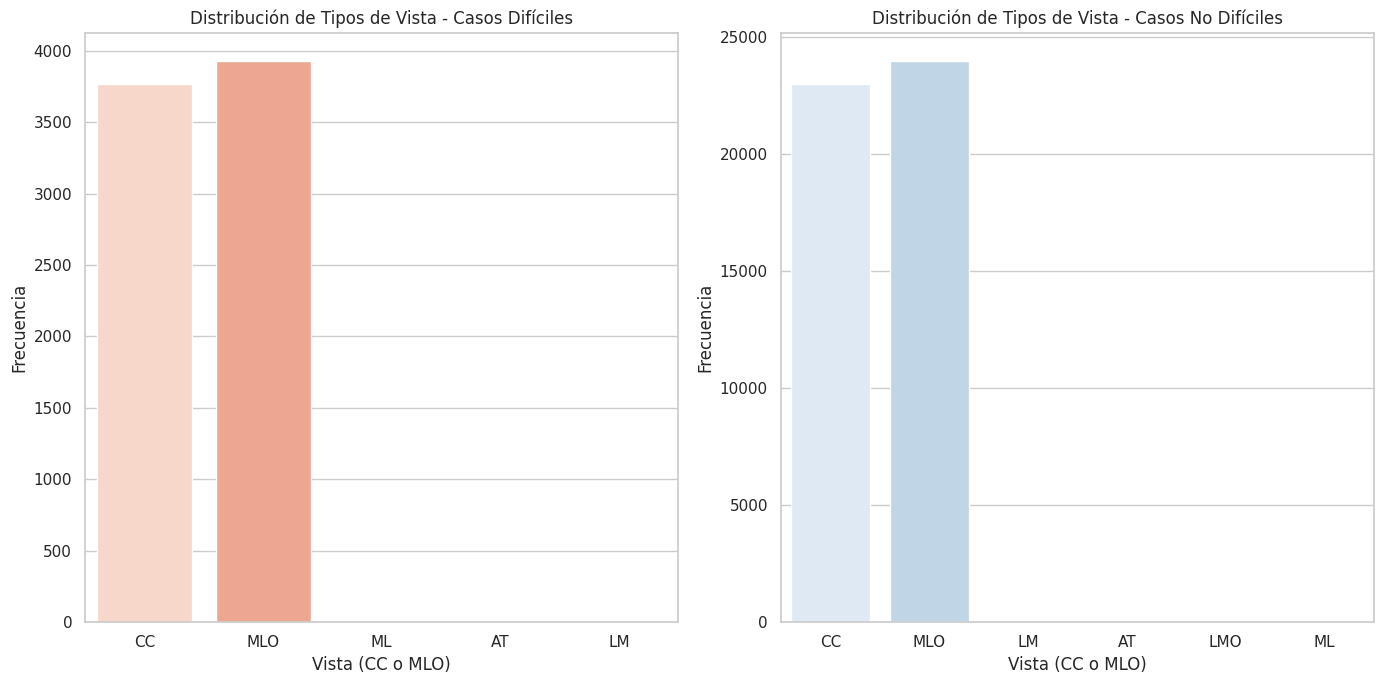

In [27]:
# Filtrar casos difíciles y no difíciles
difficult_cases = train_df[train_df['difficult_negative_case'] == True]
non_difficult_cases = train_df[train_df['difficult_negative_case'] == False]

# Configurar estilo visual
sns.set(style="whitegrid")

# Comparar la edad en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(difficult_cases['age'], kde=True, bins=20, color='red', label='Difícil')
plt.title('Distribución de Edad - Casos Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(non_difficult_cases['age'], kde=True, bins=20, color='blue', label='No Difícil')
plt.title('Distribución de Edad - Casos No Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Comparar el tipo de vista en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(data=difficult_cases, x='view', palette='Reds')
plt.title('Distribución de Tipos de Vista - Casos Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.countplot(data=non_difficult_cases, x='view', palette='Blues')
plt.title('Distribución de Tipos de Vista - Casos No Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Modelo

In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22775 entries, 46268 to 30643
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  22775 non-null  int64  
 1   patient_id               22775 non-null  int64  
 2   image_id                 22775 non-null  int64  
 3   laterality               22775 non-null  object 
 4   view                     22775 non-null  object 
 5   age                      22762 non-null  float64
 6   cancer                   22775 non-null  int64  
 7   biopsy                   22775 non-null  int64  
 8   invasive                 22775 non-null  int64  
 9   BIRADS                   22775 non-null  float64
 10  implant                  22775 non-null  int64  
 11  density                  22775 non-null  object 
 12  machine_id               22775 non-null  int64  
 13  difficult_negative_case  22775 non-null  bool   
 14  img_path               

In [ ]:
# Filtrar las filas con view "MLO" y "CC" con cancer
mlo_data = train_df[train_df['view'] == 'MLO']
cc_cancer_data = train_df[(train_df['view'] == 'CC') & (train_df['cancer'] == 1)]

# Combinar los dos subconjuntos
filtered_data = pd.concat([mlo_data, cc_cancer_data])

# Dividir en conjuntos de entrenamiento y validación con estratificación
train_data, val_data = train_test_split(
    filtered_data,
    test_size=0.2,
    random_state=42,
    stratify=filtered_data['cancer']  # Estratificar según la columna 'cancer'
)

# Resultados
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de validación: {len(val_data)}")
print(f"Proporción de 'cancer' en entrenamiento:\n{train_data['cancer'].value_counts(normalize=True)}")
print(f"Proporción de 'cancer' en validación:\n{val_data['cancer'].value_counts(normalize=True)}")

Tamaño del conjunto de entrenamiento: 22775
Tamaño del conjunto de validación: 5694
Proporción de 'cancer' en entrenamiento:
cancer
0    0.959385
1    0.040615
Name: proportion, dtype: float64
Proporción de 'cancer' en validación:
cancer
0    0.959431
1    0.040569
Name: proportion, dtype: float64


In [ ]:
# Crear Dataset para Pytorch con imagenes
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['img_path']
        label = row['cancer']

        # Manejo de errores al cargar la imagen
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error al cargar la imagen {img_path}: {e}")
            return None, None

        # Aplicar las transformaciones
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [30]:
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiar tamaño a 224x224 para ResNet18
    transforms.ToTensor(),  # Convertir la imagen a un tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Crear datasets de entrenamiento y validación
train_dataset = BreastCancerDataset(train_data, transform=transform)
val_dataset = BreastCancerDataset(val_data, transform=transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Cargar modelo preentrenado ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar todas las capas excepto las últimas
for param in model.parameters():
    param.requires_grad = False

# Descongelar la última capa y el último bloque para ajuste fino
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Modificar la última capa para clasificación binaria
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  

# Enviar el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Activar optimizaciones de CuDNN si las dimensiones de las imágenes son consistentes
torch.backends.cudnn.benchmark = True


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s] 


In [ ]:
# Definir la función de pérdida para clasificación binaria
criterion = nn.CrossEntropyLoss() 

# Usar optimizador Adam con tasa de aprendizaje ajustada
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Crear un GradScaler para manejar la escala de gradientes en precisión mixta
scaler = GradScaler()

In [ ]:
# Función para cálculo del F1 Score
def calculate_f1_score(true_labels, predictions):
    predictions = torch.argmax(predictions, dim=1).cpu().numpy()
    true_labels = true_labels.cpu().numpy()
    return f1_score(true_labels, predictions, average='weighted')

In [ ]:
# Función para evaluar el modelo
def evaluate_model(model, val_loader, criterion):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0
   
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
           
            # Registrar métricas
            all_labels.extend(labels)
            all_preds.extend(outputs)
   
    val_f1 = calculate_f1_score(torch.stack(all_labels), torch.stack(all_preds))
    print(f"Validation Loss: {running_loss/len(val_loader)}")
    return val_f1

In [ ]:
# Definición de función con parametros para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        # Modo entrenamiento
        model.train()
        train_loss = 0.0
        all_labels = []
        all_preds = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward y cálculo de pérdida
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward y optimización
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_labels.extend(labels)
            all_preds.extend(outputs)

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        train_f1 = calculate_f1_score(torch.stack(all_labels), torch.stack(all_preds))
        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}, Train F1: {train_f1:.4f}")
       
        # Evaluar en el conjunto de validación
        val_f1 = evaluate_model(model, val_loader, criterion)
        print(f"Validation F1: {val_f1:.4f}")

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

In [38]:
# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch 1, Loss: 0.11035182111990753, Train F1: 0.9697
Validation Loss: 0.11190445748356621
Validation F1: 0.9712
Epoch 1/5, Train Loss: 0.1104, Val Loss: 0.1119
Epoch 2, Loss: 0.10255881980665844, Train F1: 0.9709
Validation Loss: 0.11310105198429207
Validation F1: 0.9699
Epoch 2/5, Train Loss: 0.1026, Val Loss: 0.1131
Epoch 3, Loss: 0.09125496824128093, Train F1: 0.9733
Validation Loss: 0.11238240867099736
Validation F1: 0.9724
Epoch 3/5, Train Loss: 0.0913, Val Loss: 0.1124
Epoch 4, Loss: 0.07925009940426504, Train F1: 0.9760
Validation Loss: 0.1338892250761306
Validation F1: 0.9701
Epoch 4/5, Train Loss: 0.0793, Val Loss: 0.1339
Epoch 5, Loss: 0.058057960923015545, Train F1: 0.9807
Validation Loss: 0.1274979529938964
Validation F1: 0.9691
Epoch 5/5, Train Loss: 0.0581, Val Loss: 0.1275


In [ ]:
# Generar Matríz de confusión 
 
def generate_confusion_matrix(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
   
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
           
            # Predicción
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)  # Obtener la clase predicha
           
            # Almacenar etiquetas y predicciones
            all_labels.extend(labels.cpu().numpy())  # Convertir a NumPy
            all_preds.extend(predictions.cpu().numpy())
       # Crear matriz de confusión
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Cáncer", "Cáncer"])
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.show()

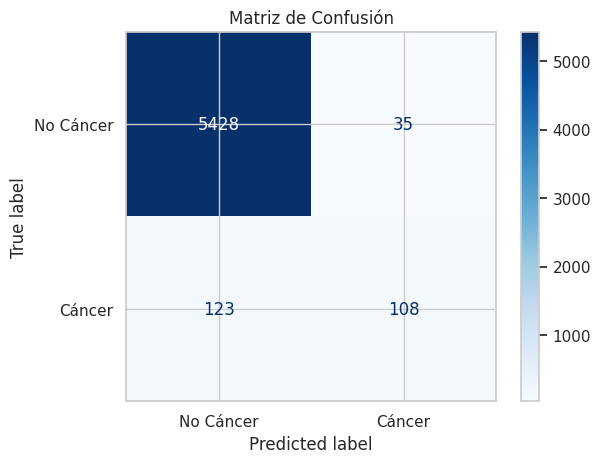

In [50]:
generate_confusion_matrix(model, val_loader)